# MNIST v2

Welcome to the programming exercise portion of Topic 5! We are going to continue using the same dataset as well as basic architecture of the Neural Network in topic 4, however applying the new optimization techniques learned in topic 5. Note that the first portion of the notebook is already written for you, as it is identical to topic 4.

### Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import tensorboard

## Preprocessing Data

In [2]:
trainset = pd.read_csv("datasets/train.csv")
testset = pd.read_csv("datasets/test.csv")

trainset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preparing the Training Examples

In [3]:
# gets all the rows, and all columns AFTER the first one
features = trainset.iloc[:, 1:].to_numpy()

print(f"features shape: {features.shape}")


features shape: (42000, 784)


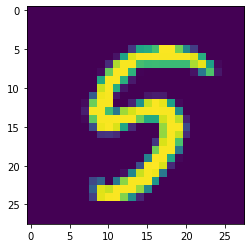

In [4]:
plt.imshow(features[8].reshape(28, 28))
plt.show()

In [5]:
# creates one-hot encoding out of the label-encoded classes
labels_dummy = pd.get_dummies(trainset['label'])
labels_dummy

labels = labels_dummy.to_numpy()
print(f"labels shape: {labels.shape}")

labels shape: (42000, 10)


### Preparing the Test Set

In [6]:
testset

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


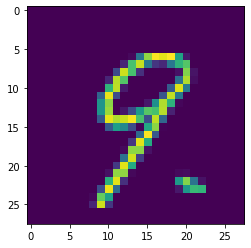

In [7]:
features_test = testset.to_numpy()
plt.imshow(features_test[2].reshape(28, 28))
plt.show()

### Checking for Imbalanced Classes

In [8]:
# count the number of items in each class
print(np.sum(labels, axis=0))

[4132 4684 4177 4351 4072 3795 4137 4401 4063 4188]


### Train-CV Split

In [9]:
from sklearn.model_selection import train_test_split

# Train/CV split using the training data.
# The testing data contains no labels, thus we cannot create CV set from it
X_train, X_cv, Y_train, Y_cv = train_test_split(features, labels, test_size=0.1)

### Data Generator

This is where we are going to implement a data generator to break up our dataset into mini-batches. While the mnist-digits dataset is technically small enough to fit into memory, we will build a data generator anyways for your practice.

In [10]:
def gen(X, Y, batch_size=32):
    start = 0
    end = batch_size
    while True:
        X_batch = np.zeros((batch_size, X.shape[1]))
        Y_batch = np.zeros((batch_size, Y.shape[1]))
        if start + batch_size >= X.shape[0]-1:
            last_nums = X.shape[0] - start
            
            X_batch[:last_nums, :] = X[start:, :]
            Y_batch[:last_nums, :] = Y[start:, :]
            
            remaining = batch_size - last_nums
            
            X_batch[last_nums:, :] = X[:remaining, :]
            Y_batch[last_nums:, :] = Y[:remaining, :]
            end = remaining
        else:
            X_batch = X[start:end, :]
            Y_batch = Y[start:end, :]
        
        start = end
        end += batch_size
        
        X_batch_t = torch.from_numpy(X_batch).float().cuda()
        Y_batch_t = torch.from_numpy(Y_batch).float().cuda()
        yield (X_batch_t, Y_batch_t)
        del X_batch_t
        del Y_batch_t
            
        

In [11]:
test = np.arange(0, 100).reshape(-1, 1)
test

test_gen = gen(test, test)

print(next(test_gen), '\n')


(tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.],
        [27.],
        [28.],
        [29.],
        [30.],
        [31.]], device='cuda:0'), tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.],
        [25.],
        [26.],
        [27.],
        [28.],
        [29.],
        [30.],
        [31.]], device='cuda:0')) 


## Neural Network

This Neural Network will use a **3-layer** design with **900, 900,** and **10** nodes in each layer. Since the input data are images, we need to flatten the **28 x 28** images into a vector of size **784**. This network is identical to the one from topic 4; we will implement the techniques learned in `Topic 5 -- Advanced Optimization` into this model.

### Defining Our Model

In [12]:
import torch 
from torch.nn import Module, Linear, Softmax, BatchNorm1d, ReLU, Dropout
from torch.optim import Adam
from torch.nn.init import xavier_normal, kaiming_normal
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class NNv2(Module):
    def __init__(self, input_dim, output_dim, drop=0.2):
        super().__init__()
        self.bn_in = BatchNorm1d(input_dim)
        self.z1 = Linear(input_dim, 900)
        kaiming_normal(self.z1.weight)
        self.bn1 = BatchNorm1d(900)
        self.a1 = ReLU()
        self.d1 = Dropout(drop)
        
        self.z2 = Linear(900, 900)
        kaiming_normal(self.z2.weight)
        self.bn2 = BatchNorm1d(900)
        self.a2 = ReLU()     
        self.d2 = Dropout(drop)
        
        self.z3 = Linear(900, output_dim)
        xavier_normal(self.z3.weight)
        self.bn3 = BatchNorm1d(output_dim)
        self.a3 = Softmax(dim=1)  
        
        self.acc = Accuracy()
        
        self.val_loss = None
        self.val_acc = None
        self.loss = None
        self.accuracy = None
        
        
    def forward(self, x):
        x = self.bn_in(x)
        
        x = self.z1(x)
        x = self.bn1(x)
        x = self.a1(x)
        x = self.d1(x)
        
        x = self.z2(x)
        x = self.bn2(x)
        x = self.a2(x)
        x = self.d2(x)
        
        x = self.z3(x)
        x = self.bn3(x)
        x = self.a3(x)
        
        return x
    
    def fit(self, t_gen, loss_fn, opt, cv_gen=None, epochs=1, train_steps=1, val_steps=1):
        
        writer_train = SummaryWriter("runs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "-train")
        writer_val = SummaryWriter("runs/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "-val")
        
        for i in range(epochs):
            for j in range(train_steps):
                self.train()
                opt.zero_grad()
                X_train, Y_train = next(t_gen)
                
                Y_pred = self(X_train)
                
                self.loss = loss_fn(Y_pred, Y_train)
                self.accuracy = self.acc(torch.argmax(torch.round(Y_pred).int(), dim=1), torch.argmax(Y_train.int(), dim=1))
                
                
                msg = f"\rEpoch: {i+1}, Step: {j+1}/{train_steps}, loss: {self.loss.item(): .4f}, accuracy: {self.accuracy: .4f}"
                self.loss.backward()
                opt.step()
                print(msg, end="")
                
                del Y_pred

                
            if cv_gen is not None:
                self.val_loss = 0
                self.val_acc = 0
                for j in range(val_steps):
                    self.eval()
                    X_cv, Y_cv = next(cv_gen)
                    
                    Y_pred_cv = self(X_cv)
                    self.val_loss += loss_fn(Y_pred_cv, Y_cv)
                    self.val_acc += self.acc(torch.argmax(torch.round(Y_pred_cv).int(), dim=1), torch.argmax(Y_cv.int(), dim=1))
                    
                self.val_loss = self.val_loss/val_steps
                self.val_acc = torch.tensor(self.val_acc/val_steps)
                print(f", val_loss: {self.val_loss.item(): .4f}, val_accuracy: {self.val_acc.item(): .4f}", end="")
                
                
                
            print(" ")
            writer_train.add_scalar("loss", self.loss, i)
            writer_train.add_scalar("accuracy", self.accuracy, i)
            writer_val.add_scalar("loss", self.val_loss, i)
            writer_val.add_scalar("accuracy", self.val_acc, i)
                
            
            
def CCE(Y_pred, Y_true):
    Y_pred = 0.9999999*Y_pred + (1-0.9999999)/2
    ylogy = -Y_true * torch.log(Y_pred)
    sum_across = torch.sum(ylogy, dim=1)
    sum_down = torch.sum(sum_across, dim=0)/Y_true.shape[0]
    return sum_down
                
                

/home/zonyyu/Documents/Programming Projects/Project Files/M2MTech/Beginner AI Course/workshop-5-advanced-optimizations/env/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Test Train

Before the Hyperparameter Search process, let's test out training our model just to make sure that it works.

In [13]:
input_dim, output_dim = (X_train.shape[1], 10)

EPOCHS = 10
BATCH_SIZE = 64

### Hyperparameters ###
LEARNING_RATE = 1e-3
L2 = 1e-8
DROP = 0.2
#######################





T_STEPS = int(X_train.shape[0]/BATCH_SIZE)
V_STEPS = int(X_cv.shape[0]/BATCH_SIZE)
t_gen = gen(X_train, Y_train, BATCH_SIZE)
v_gen = gen(X_cv, Y_cv, BATCH_SIZE)

model = NNv2(input_dim, output_dim, drop=DROP).cuda()
optimizer = Adam(model.parameters(), weight_decay=L2, lr=LEARNING_RATE)
criterion = CCE

model.fit(t_gen, criterion, optimizer, epochs=EPOCHS, train_steps=T_STEPS, cv_gen=v_gen, val_steps=V_STEPS)

Epoch: 1, Step: 11/590, loss:  0.9104, accuracy:  0.4531

<ipython-input-12-12209cbff92e>:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.z1.weight)
<ipython-input-12-12209cbff92e>:20: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.z2.weight)
<ipython-input-12-12209cbff92e>:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  xavier_normal(self.z3.weight)


Epoch: 1, Step: 590/590, loss:  0.2976, accuracy:  0.9062

<ipython-input-12-12209cbff92e>:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_acc = torch.tensor(self.val_acc/val_steps)


, val_loss:  0.3131, val_accuracy:  0.9286 
Epoch: 2, Step: 590/590, loss:  0.1435, accuracy:  0.9688, val_loss:  0.2505, val_accuracy:  0.9522 
Epoch: 3, Step: 590/590, loss:  0.1476, accuracy:  0.9375, val_loss:  0.2216, val_accuracy:  0.9558 
Epoch: 4, Step: 590/590, loss:  0.1210, accuracy:  0.9531, val_loss:  0.2028, val_accuracy:  0.9627 
Epoch: 5, Step: 590/590, loss:  0.1011, accuracy:  0.9531, val_loss:  0.1938, val_accuracy:  0.9656 
Epoch: 6, Step: 590/590, loss:  0.0637, accuracy:  0.9844, val_loss:  0.1957, val_accuracy:  0.9637 
Epoch: 7, Step: 590/590, loss:  0.0362, accuracy:  1.0000, val_loss:  0.2131, val_accuracy:  0.9637 
Epoch: 8, Step: 590/590, loss:  0.0439, accuracy:  0.9844, val_loss:  0.1974, val_accuracy:  0.9654 
Epoch: 9, Step: 590/590, loss:  0.0180, accuracy:  1.0000, val_loss:  0.1880, val_accuracy:  0.9671 
Epoch: 10, Step: 590/590, loss:  0.0527, accuracy:  0.9844, val_loss:  0.2044, val_accuracy:  0.9675 


## Hyperparameter Search

The final task in this notebook is to search for hyperparameters. Here we are going to create a random search algorithm to train multiple models and evaluate each one.

In [14]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


input_dim, output_dim = (X_train.shape[1], 10)

EPOCHS = 100
NUM_MODELS = 1
BATCH_SIZE = 1024

### Hyperparameters ###
LEARNING_RATE = np.random.uniform(2e-3, 5e-3, NUM_MODELS)
L2 = np.random.uniform(5e-5, 9e-5, NUM_MODELS)
DROP = np.random.uniform(0.4, 0.6, NUM_MODELS)#0.4, 0.6
#######################



T_STEPS = int(X_train.shape[0]/BATCH_SIZE)
V_STEPS = int(X_cv.shape[0]/BATCH_SIZE)
t_gen = gen(X_train, Y_train, BATCH_SIZE)
v_gen = gen(X_cv, Y_cv, BATCH_SIZE)

hparams = pd.DataFrame(columns=['val_acc', 'val_loss', 'L2', 'Learning Rate', 'Dropout'])
model=None

for i in range(NUM_MODELS):
    

    
    print(f"##### MODEL {i+1}/{NUM_MODELS} #####")
    model = NNv2(input_dim, output_dim, drop=DROP[i]).cuda()
    optimizer = Adam(model.parameters(), weight_decay=L2[i], lr=LEARNING_RATE[i])
    criterion = CCE

    model.fit(t_gen, criterion, optimizer, epochs=EPOCHS, train_steps=T_STEPS, cv_gen=v_gen, val_steps=V_STEPS)
    
    
    history = pd.DataFrame([[model.val_acc.cpu().item(), model.val_loss.cpu().item(), L2[i], LEARNING_RATE[i], DROP[i]]], 
                          columns=['val_acc', 'val_loss', 'L2', 'Learning Rate', 'Dropout'])
    hparams = hparams.append(history, ignore_index=True)
    
    
    print('\n\n')
    
#     del model
#     del optimizer
#     del criterion

##### MODEL 1/1 #####
Epoch: 1, Step: 15/36, loss:  0.6266, accuracy:  0.7285

<ipython-input-12-12209cbff92e>:14: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.z1.weight)
<ipython-input-12-12209cbff92e>:20: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(self.z2.weight)
<ipython-input-12-12209cbff92e>:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  xavier_normal(self.z3.weight)


Epoch: 1, Step: 36/36, loss:  0.4679, accuracy:  0.8066, val_loss:  0.3989, val_accuracy:  0.8606 
Epoch: 2, Step: 18/36, loss:  0.3761, accuracy:  0.8594

<ipython-input-12-12209cbff92e>:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_acc = torch.tensor(self.val_acc/val_steps)


Epoch: 2, Step: 36/36, loss:  0.3250, accuracy:  0.8926, val_loss:  0.3287, val_accuracy:  0.9104 
Epoch: 3, Step: 36/36, loss:  0.2342, accuracy:  0.9268, val_loss:  0.2470, val_accuracy:  0.9424 
Epoch: 4, Step: 36/36, loss:  0.1677, accuracy:  0.9639, val_loss:  0.1880, val_accuracy:  0.9558 
Epoch: 5, Step: 36/36, loss:  0.1454, accuracy:  0.9707, val_loss:  0.1643, val_accuracy:  0.9641 
Epoch: 6, Step: 36/36, loss:  0.1229, accuracy:  0.9678, val_loss:  0.1370, val_accuracy:  0.9690 
Epoch: 7, Step: 36/36, loss:  0.1011, accuracy:  0.9785, val_loss:  0.1275, val_accuracy:  0.9707 
Epoch: 8, Step: 36/36, loss:  0.0922, accuracy:  0.9795, val_loss:  0.1100, val_accuracy:  0.9731 
Epoch: 9, Step: 36/36, loss:  0.0730, accuracy:  0.9805, val_loss:  0.1011, val_accuracy:  0.9741 
Epoch: 10, Step: 36/36, loss:  0.0828, accuracy:  0.9785, val_loss:  0.0947, val_accuracy:  0.9753 
Epoch: 11, Step: 36/36, loss:  0.0622, accuracy:  0.9854, val_loss:  0.0940, val_accuracy:  0.9756 
Epoch: 1

Epoch: 84, Step: 36/36, loss:  0.0239, accuracy:  0.9932, val_loss:  0.0691, val_accuracy:  0.9817 
Epoch: 85, Step: 36/36, loss:  0.0354, accuracy:  0.9893, val_loss:  0.0686, val_accuracy:  0.9807 
Epoch: 86, Step: 36/36, loss:  0.0425, accuracy:  0.9844, val_loss:  0.0747, val_accuracy:  0.9824 
Epoch: 87, Step: 36/36, loss:  0.0381, accuracy:  0.9863, val_loss:  0.0763, val_accuracy:  0.9797 
Epoch: 88, Step: 36/36, loss:  0.0509, accuracy:  0.9805, val_loss:  0.0720, val_accuracy:  0.9797 
Epoch: 89, Step: 36/36, loss:  0.0293, accuracy:  0.9893, val_loss:  0.0765, val_accuracy:  0.9773 
Epoch: 90, Step: 36/36, loss:  0.0298, accuracy:  0.9922, val_loss:  0.0731, val_accuracy:  0.9792 
Epoch: 91, Step: 36/36, loss:  0.0318, accuracy:  0.9844, val_loss:  0.0774, val_accuracy:  0.9802 
Epoch: 92, Step: 36/36, loss:  0.0366, accuracy:  0.9902, val_loss:  0.0716, val_accuracy:  0.9805 
Epoch: 93, Step: 36/36, loss:  0.0304, accuracy:  0.9941, val_loss:  0.0735, val_accuracy:  0.9797 


In [15]:
hparams = hparams.sort_values(by=['val_acc'], ascending=False)
hparams

,val_acc,val_loss,L2,Learning Rate,Dropout
0,0.978271,0.07363,0.00007,0.004842,0.412494


In [16]:
%load_ext tensorboard
%tensorboard --logdir runs

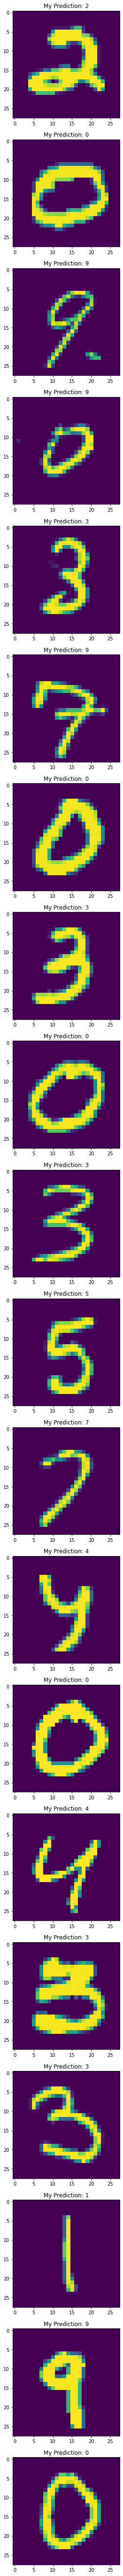

In [22]:
model.cpu().eval()

# make predictions on the first 20 examples of X_test_t
Y_test_t = model(torch.from_numpy(features_test[:20, :]).float())

# Convert the first 20 examples from torch.tensor
# to np.ndarray so we can plot it
X_test = features_test[:20, :]
Y_test = Y_test_t.cpu().detach().numpy()

# Create subplots with 20 subplots
fig, axes = plt.subplots(X_test.shape[0], 1, figsize=(100, 100))

# each element in axes will contain an image plot
for i in range(X_test.shape[0]):
    axes[i].imshow(X_test[i].reshape((28, 28)))
    axes[i].title.set_text(f'My Prediction: {np.argmax(Y_test, axis=1)[i]}')
    
plt.show()

In [ ]:
tscript = torch.jit.trace(model.cpu(), torch.rand((1, 784)))
tscript.save('mnist_predictor.pt')